In [1]:
import os

import datetime as dt
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
from scipy.interpolate import interp1d
import configparser

import modules.load_data as ld
from CAMS_aerosol_props.load_cams_data import CAMS
from modules.modules_FIG03 import *

# paths
config = configparser.ConfigParser()
config.read("ConfigFile.ini")
pf = config['PATHS']['datasets']

camsra_fname_2015 = os.path.join(pf,'CAMSRA/cams-ra_2015-*_{ftype}.nc')
camsra_fname = os.path.join(pf,'CAMSRA/cams-ra_2015-01-01_{ftype}.nc')

#TCARS data
TCARS_fname = os.path.join(pf,"TCARS_spectral_aerosol_props_2015.nc")

In [2]:
TCARS = xr.open_dataset(TCARS_fname)
AP = TCARS.mean(dim=['lat','lon'],skipna=True)
AP_seas = AP.groupby('time.season').mean(skipna=True)
AP_year = AP.mean(dim=['time'],skipna=True)
mext = (AP_seas.aod/AP_seas.mass).values

 In order to calculate aerosol type dependend mass fraction and AOD fraction. The aerosol mass dependen on aerosol type is taken from the CAMSRA dataset

In [3]:
def get_mass(select,DS):
    MASS = np.zeros(DS.aermsssss.shape)
    for key in DS.keys():
        if key[:len(select)]!=select:
            continue
        MASS+=DS[key].values
    return MASS

def get_allmass(DS):
    MASSES=[]
    for select in ['aermss','aermssss','aermssdu','aermssom','aermssbc','aermsssu']:
        MASSES.append(get_mass(select,DS))
    return MASSES
CAMSsfc = xr.open_mfdataset(camsra_fname_2015.format(ftype='sfc'),combine='by_coords')
dropvars = [ var for var in CAMSsfc.keys() if var[:3]!='aer' ] 
CAMSsfc = CAMSsfc.drop_vars(dropvars).compute()
CAMSsfc = CAMSsfc.mean(dim=['lat','lon'],skipna=True)
CAMSsfc_seas=CAMSsfc.groupby('time.season').mean(dim=['time'],skipna=True)

## Masses
#####################################################################################
MASSES_all2 = get_allmass(CAMSsfc_seas)

a
b
c
d
e
f
g


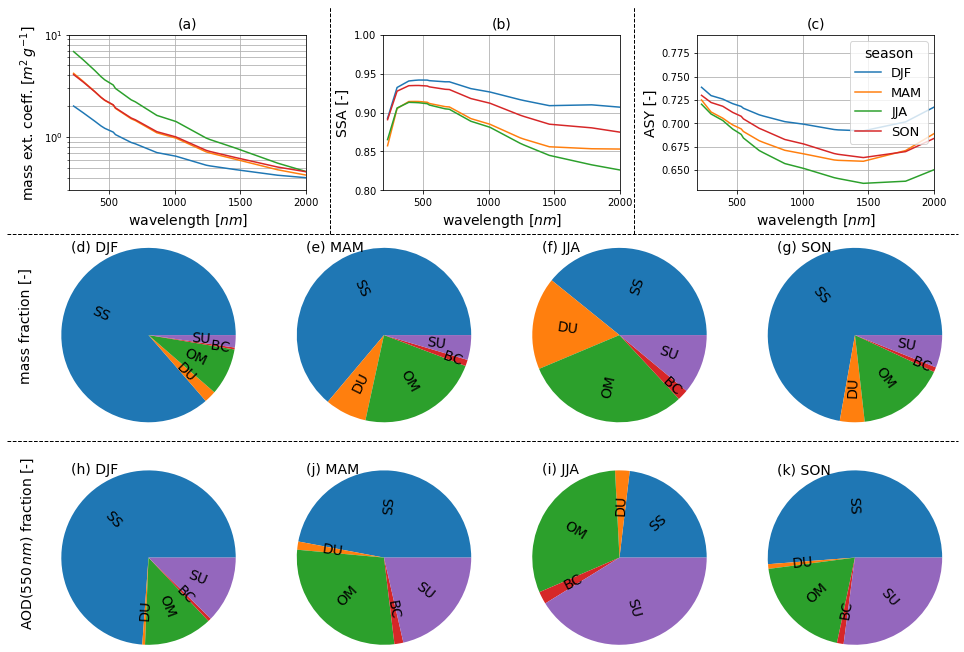

In [5]:
## Plot
###################################################################################

fig = plt.figure(figsize=(13.2,9)) # 3 rows

## Spectral aerosol props
####################################################################################
print('a')
## mass extinction coeff
ax = plt.subplot2grid((3,12),(0,0),colspan=4)
ax.set_title('(a)',fontsize=14)
ax.set_xlim([200,2000])
ax.set_yscale('log')
ax.plot(AP_seas.wvl,mext[[0,2,1,3],:].T)
ax.set_ylim([0.3,10])
ax.tick_params('y',which='minor',labelleft=True)
ax.grid(True,which='both')
ax.set_xlabel(r'wavelength [$nm$]',fontsize=14)
ax.set_ylabel(r"mass ext. coeff. $\left[m^2\,g^{-1}\right]$",fontsize=14)#,fontweight='bold')
print('b')
## single scattering albedo
ax2 = plt.subplot2grid((3,12),(0,4),colspan=4)
ax2.set_title('(b)',fontsize=14)
ax2.set_xlim([200,2000])
ax2.plot(AP_seas.wvl,AP_seas.ssa[[0,2,1,3],:].T)
ax2.set_ylim([0.8,1])
ax2.grid(True)
ax2.set_xlabel(r'wavelength [$nm$]',fontsize=14)
ax2.set_ylabel("SSA [-]",fontsize=14)#,fontweight='bold')
print('c')
## asymmetry parameter
ax3 = plt.subplot2grid((3,12),(0,8),colspan=4)
ax3.set_title('(c)',fontsize=14)
ax3.set_xlim([200,2000])
ax3.plot(AP_seas.wvl,AP_seas.g[[0,2,1,3],:].T)# *1e-3
ax3.grid(True)
ax3.legend(AP_seas.season.values[[0,2,1,3]],title='season',fontsize=13,title_fontsize=14)
ax3.set_xlabel(r'wavelength [$nm$]',fontsize=14)
ax3.set_ylabel("ASY [-]",fontsize=14)#,fontweight='bold')

axs=[ax,ax2,ax3]

## Mass Fraction Pie Charts
###################################################################################

print('d')
titles = ['(d) DJF','(f) JJA','(e) MAM','(g) SON']
for i,I in enumerate([0,2,1,3]):
    M = [float(m[I])/float(MASSES_all2[0][I]) for m in MASSES_all2[1:]]
    ax = plt.subplot2grid((3,12),(1,i*3),colspan=3)

    axs.append(ax)
    ax.set_title(titles[I],fontsize=14,loc='left')
    ax.pie(M,labels=['SS','DU','OM','         BC','SU'],radius=1.4,rotatelabels=True,labeldistance=0.6,
            textprops=dict(fontsize=14,#fontweight='bold',
                           verticalalignment='center',
                           horizontalalignment='center'))
    
## Mass Fraction * Extinction  Pie Charts
###################################################################################
print('e')

# calculate aod at 550 nm for each aerosol type at relative humidity at 50%
C = CAMS(cams_sfc_file = camsra_fname.format(ftype='sfc'),
         cams_ml_file = camsra_fname.format(ftype='ml'),
         opt_prop_file = "CAMS_aerosol_props/aerosol_cams_ifs_optics.nc")
C.rh=50.

atypes = ['SS1','SS2','SS3','DU1','DU2','DU3','OM1','OM2','BC1','BC2','SU']


Amexts=[]
for i,atyp in enumerate(atypes): 
    props=C.get_aerosol_props(atyp,550.,mono=True)
    _,Amext,_,_=props
    Amexts.append(Amext[0,0])
Amexts = np.array([np.mean(Amexts[:3]),
                   np.mean(Amexts[3:6]),
                   np.mean(Amexts[6:8]),
                   np.mean(Amexts[8:10]),
                   Amexts[10]])
print('f')
titles = ['(h) DJF','(i) JJA','(j) MAM','(k) SON']
for i,I in enumerate([0,2,1,3]):
    AODs = np.array([Amexts[mi]*float(m[I]) for mi,m in enumerate(MASSES_all2[1:])])
    AODs/= np.sum(AODs)
    ax = plt.subplot2grid((3,12),(2,i*3),colspan=3)
    axs.append(ax)
    ax.set_title(titles[I],fontsize=14,loc='left')
    ax.pie(AODs,labels=['SS','DU','OM','BC','SU'],radius=1.4,rotatelabels=True,labeldistance=0.6,
            textprops=dict(fontsize=14,#fontweight='bold',
                           verticalalignment='center',
                           horizontalalignment='center'))

    
print('g')    
## layout and separators
###################################################################################
plt.tight_layout() 
# plt.subplots_adjust(wspace=10,hspace=0.5)
ax.annotate(r'AOD(550$\,nm$) fraction [-]',(0.02,1./6.),xycoords='figure fraction',
            fontsize=14,#fontweight='bold',
            rotation='vertical',
            ha='left',va='center')
ax.annotate('mass fraction [-]',(0.02,0.5),xycoords='figure fraction',
            fontsize=14,#fontweight='bold',
            rotation='vertical',
            ha='left',va='center')

# Get the bounding boxes of the axes including text decorations
r = fig.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
bbox1 = get_bbox(ax2)
bbox2 = get_bbox(ax)
#Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array([bbox1.y1,bbox2.y1])
ymin = np.array([bbox1.y0,bbox2.y0])
# ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)
ys = [0.33,0.65]
# Draw a horizontal lines at those coordinates
for y in ys:
    line = plt.Line2D([0,1],[y,y], transform=fig.transFigure, color="black",linestyle='--',linewidth=1)
    fig.add_artist(line)
xs=[0.34,0.66]
for x in xs:
    line = plt.Line2D([x,x],[0.65,1], transform=fig.transFigure, color="black",linestyle='--',linewidth=1)
    fig.add_artist(line)
    
# plt.tight_layout()
fig.savefig('figures/Fig09.pdf',dpi=300,bbox_inches='tight')

    